In [1]:
import pandas as pd
import os
import kagglehub

path = kagglehub.dataset_download("polartech/second-hand-luxury-bagswatches-dataset")
print(os.listdir(path))

['bags.csv']


In [2]:
df = pd.read_csv(os.path.join(path, 'bags.csv'))
df = df[['PRICE_RETAIL', 'CONDITION', 'CATEGORY', 'BRAND', 'PRIMARY_MARKET_PRICE']]

In [4]:
## General Information

print(df.info())
print(df.isnull().sum())
print(df.describe())

print(df['CONDITION'].unique())
print(df['CATEGORY'].unique())
print(df['BRAND'].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRICE_RETAIL          999 non-null    float64
 1   CONDITION             999 non-null    object 
 2   CATEGORY              999 non-null    object 
 3   BRAND                 999 non-null    object 
 4   PRIMARY_MARKET_PRICE  527 non-null    float64
dtypes: float64(2), object(3)
memory usage: 39.2+ KB
None
PRICE_RETAIL              0
CONDITION                 0
CATEGORY                  0
BRAND                     0
PRIMARY_MARKET_PRICE    472
dtype: int64
       PRICE_RETAIL  PRIMARY_MARKET_PRICE
count    999.000000            527.000000
mean    1800.470470           1963.929791
std     1984.262186           1235.541940
min      125.000000            365.000000
25%      775.000000           1165.000000
50%     1255.000000           1790.000000
75%     2095.000000           2450

In [5]:
# Brand-level mean fill
df['PRIMARY_MARKET_PRICE'] = df.groupby('BRAND')['PRIMARY_MARKET_PRICE']\
                                .transform(lambda x: x.fillna(x.mean()))

# Fill remaining NaNs (brands with no valid values) using global mean
df['PRIMARY_MARKET_PRICE'] = df['PRIMARY_MARKET_PRICE'].fillna(df['PRIMARY_MARKET_PRICE'].mean())


In [6]:
## Price difference between retail and market

df['price_diff'] = df['PRICE_RETAIL'] - df['PRIMARY_MARKET_PRICE']
df['price_ratio'] = df['PRICE_RETAIL'] / df['PRIMARY_MARKET_PRICE']

print("Average Price Difference (Retail - Primary):", df['price_diff'].mean())
print("Average Price Ratio (Retail / Primary):", df['price_ratio'].mean())


Average Price Difference (Retail - Primary): -408.10825051691904
Average Price Ratio (Retail / Primary): 0.7683483087722168


In [12]:
# Number of items where resale price > original price
num_price_increase = (df['PRICE_RETAIL'] > df['PRIMARY_MARKET_PRICE']).sum()

# Percentage of total
percent_increased = (num_price_increase / len(df)) * 100

print(f"Number of items with price increase: {num_price_increase}")
print(f"Percentage of total: {percent_increased:.2f}%")


Number of items with price increase: 145
Percentage of total: 14.51%


In [16]:
# Count of appreciated items per brand
appreciated_count = df[df['PRICE_RETAIL'] > df['PRIMARY_MARKET_PRICE']]['BRAND'].value_counts()

# Total number of items per brand
total_count = df['BRAND'].value_counts()

# Appreciation percentage per brand
appreciation_percentage = (appreciated_count / total_count * 100).round(2)

# Combine into a summary DataFrame
brand_appreciation_summary = pd.DataFrame({
    'Appreciated_Count': appreciated_count,
    'Total_Count': total_count,
    'Appreciation_Percentage': appreciation_percentage
}).fillna(0).sort_values('Appreciation_Percentage', ascending=False)

print(brand_appreciation_summary.head(10))  # Top 10 brands with most appreciation


               Appreciated_Count  Total_Count  Appreciation_Percentage
BRAND                                                                 
hermes                      15.0           41                    36.59
chanel                      47.0          141                    33.33
goyard                       3.0           10                    30.00
louis vuitton               51.0          281                    18.15
fendi                        4.0           31                    12.90
saint laurent                5.0           49                    10.20
mcm                          2.0           21                     9.52
gucci                       13.0          171                     7.60
balenciaga                   3.0           40                     7.50
burberry                     1.0           30                     3.33


/var/folders/wb/rq160ygd0dq8tn0_wr6q5lkm0000gn/T/ipykernel_27443/991899493.py:22: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  plt.tight_layout()
/Users/banutiryaki/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


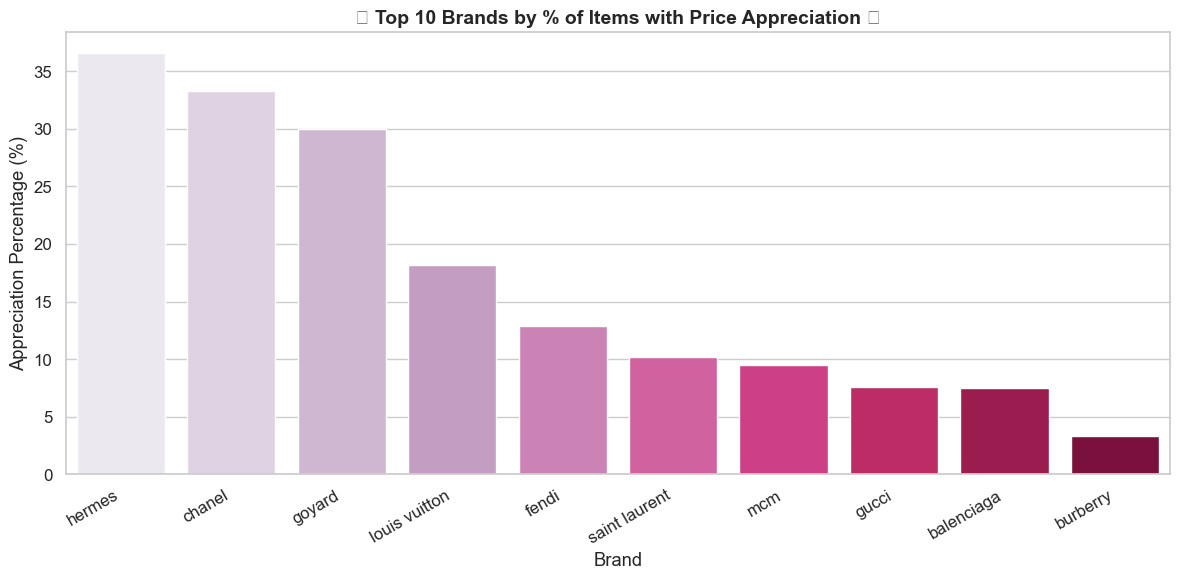

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set theme
sns.set_theme(style="whitegrid", font_scale=1.1)

# Define the palette using seaborn's built-in 'PuRd'
palette = sns.color_palette('PuRd', n_colors=len(top_brands))

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_brands.index,
    y=top_brands['Appreciation_Percentage'],
    palette=palette
)

plt.title("✨ Top 10 Brands by % of Items with Price Appreciation ✨", fontsize=14, weight='bold')
plt.ylabel("Appreciation Percentage (%)")
plt.xlabel("Brand")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [8]:
## price by condition

condition_summary = df.groupby('CONDITION')['PRICE_RETAIL'].agg(['count', 'mean', 'median', 'min', 'max'])\
                      .sort_values('mean', ascending=False)
print("Condition-Based Retail Price Summary:")
print(condition_summary)


Condition-Based Retail Price Summary:
           count         mean  median     min      max
CONDITION                                             
giftable      21  4782.619048  3750.0   400.0  27950.0
excellent    539  2015.667904  1460.0   260.0  25150.0
new           23  1876.086957  1255.0   565.0   5455.0
flawed         1  1570.000000  1570.0  1570.0   1570.0
very good    398  1375.414573  1035.0   125.0  11125.0
fair           1  1190.000000  1190.0  1190.0   1190.0
good          16  1154.062500  1052.5   655.0   2795.0


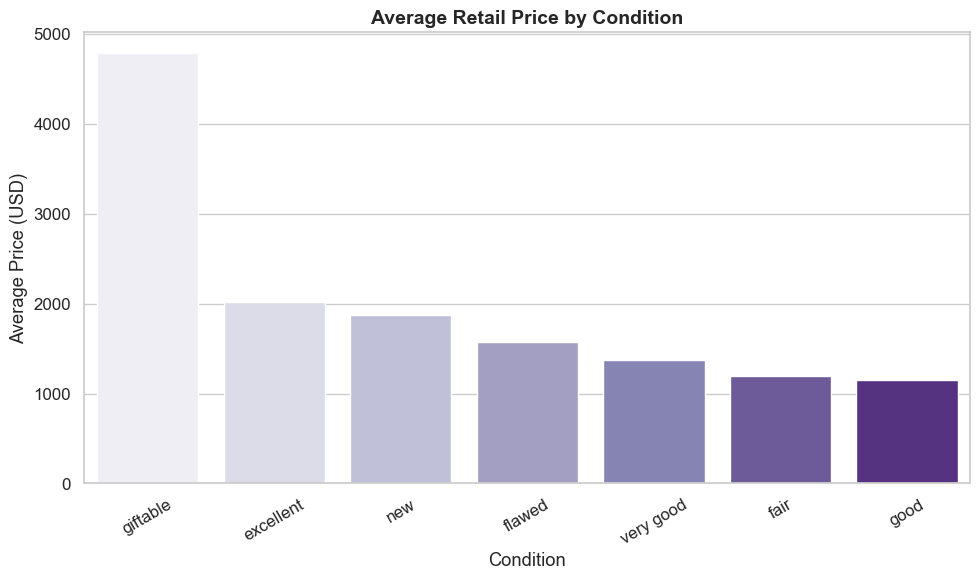

In [23]:
## price by condition histogram

sns.set_theme(style="whitegrid", font_scale=1.1)

valid_palette = sns.color_palette("Purples", n_colors=len(condition_summary))

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    x=condition_summary.index,
    y=condition_summary['mean'],
    palette=valid_palette
)

plt.title("Average Retail Price by Condition", fontsize=14, weight='bold')
plt.ylabel("Average Price (USD)")
plt.xlabel("Condition")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [10]:
## price by category

category_summary = df.groupby('CATEGORY')['PRICE_RETAIL'].agg(['count', 'mean', 'median', 'min', 'max'])\
                     .sort_values('mean', ascending=False)
print("\nCategory-Based Retail Price Summary:")
print(category_summary)



Category-Based Retail Price Summary:
                       count         mean  median    min      max
CATEGORY                                                         
shop all bags            120  2870.833333  1622.5  340.0  27950.0
bucket bags              120  1921.666667  1525.0  305.0   6715.0
backpacks                240  1831.895833  1337.5  325.0  13600.0
belt bags                399  1523.884712  1045.0  125.0   5765.0
clutch & evening bags    120  1465.708333  1002.5  260.0   9885.0


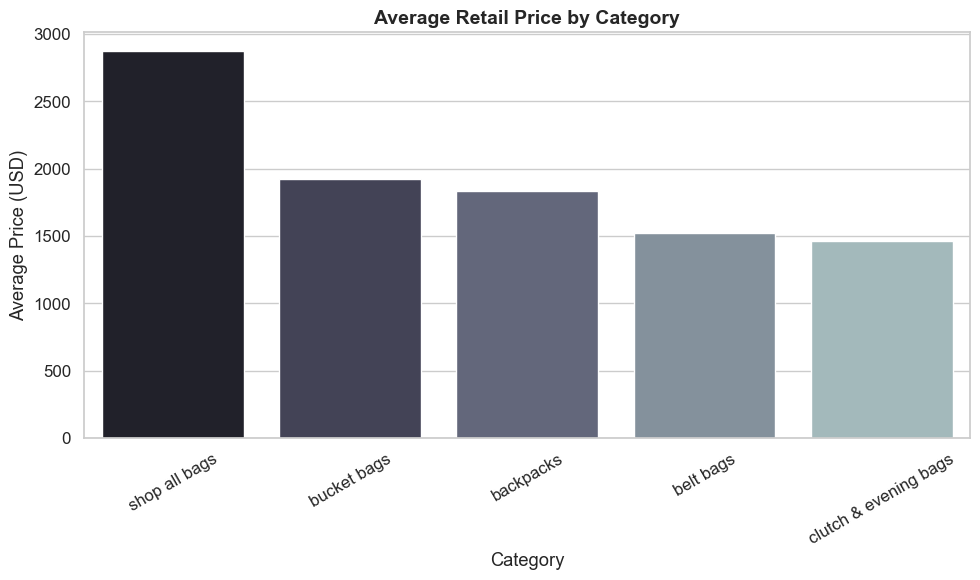

In [25]:
## price by category histogram

sns.set_theme(style="whitegrid", font_scale=1.1)

category_summary = df.groupby('CATEGORY')['PRICE_RETAIL'].agg(['count', 'mean', 'median', 'min', 'max'])\
                     .sort_values('mean', ascending=False)

category_palette = sns.color_palette(palette='bone')


# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    x=category_summary.index,
    y=category_summary['mean'],
    palette=category_palette
)

plt.title("Average Retail Price by Category", fontsize=14, weight='bold')
plt.ylabel("Average Price (USD)")
plt.xlabel("Category")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [11]:
## Brand summary

brand_summary = df.groupby('BRAND')[['PRICE_RETAIL', 'PRIMARY_MARKET_PRICE']].mean()
brand_summary['avg_price_diff'] = brand_summary['PRICE_RETAIL'] - brand_summary['PRIMARY_MARKET_PRICE']
brand_summary['avg_price_ratio'] = brand_summary['PRICE_RETAIL'] / brand_summary['PRIMARY_MARKET_PRICE']
brand_summary = brand_summary.sort_values('avg_price_ratio', ascending=False)

print("\nBrand-Level Pricing Trends:")
print(brand_summary)



Brand-Level Pricing Trends:
                     PRICE_RETAIL  PRIMARY_MARKET_PRICE  avg_price_diff  \
BRAND                                                                     
hermes                6391.463415           5425.000000      966.463415   
chanel                3522.446809           3844.042553     -321.595745   
moynat                4090.000000           4500.000000     -410.000000   
goyard                3027.500000           3382.500000     -355.000000   
louis vuitton         1753.256228           2137.861635     -384.605407   
christian louboutin    752.500000            950.000000     -197.500000   
loewe                 1560.000000           1990.000000     -430.000000   
saint laurent         1127.653061           1482.500000     -354.846939   
christian dior        1803.709677           2402.352941     -598.643264   
mansur gavriel         475.000000            645.000000     -170.000000   
gucci                  957.573099           1351.842105     -394.269006

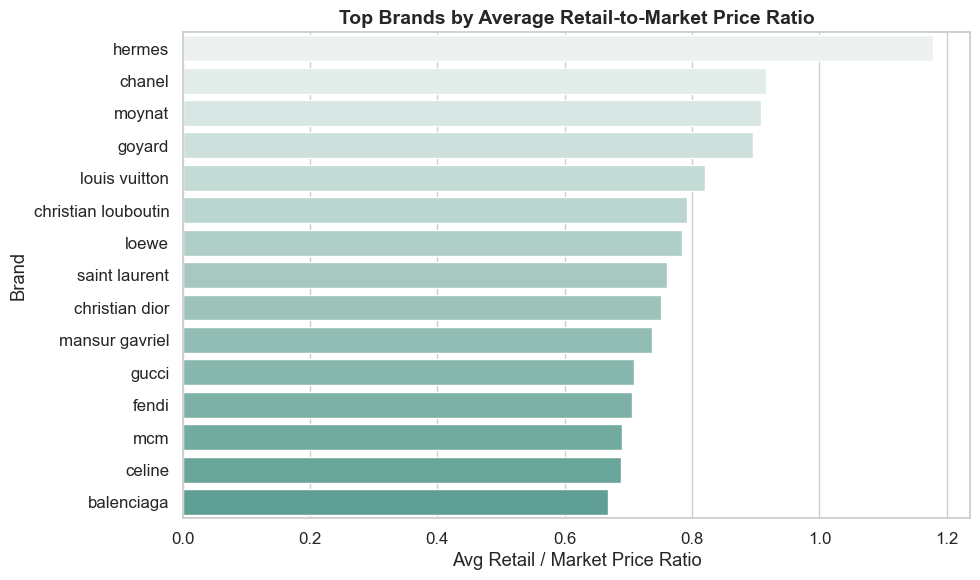

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort and limit to top N for readability (optional)
top_n = 15
top_brands_ratio = brand_summary.sort_values('avg_price_ratio', ascending=False).head(top_n)

# Set theme
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))

# Plot
sns.barplot(
    x=top_brands_ratio['avg_price_ratio'],
    y=top_brands_ratio.index,
    palette="light:#5A9"
)

plt.title("Top Brands by Average Retail-to-Market Price Ratio", fontsize=14, weight='bold')
plt.xlabel("Avg Retail / Market Price Ratio")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()


In [27]:
# Count listings per brand
brand_counts = df['BRAND'].value_counts()

# Keep only brands with at least 5 listings
valid_brands = brand_counts[brand_counts >= 5].index

# Filter the dataset
df = df[df['BRAND'].isin(valid_brands)]


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

features = ['PRIMARY_MARKET_PRICE', 'CONDITION', 'CATEGORY', 'BRAND']
target = 'PRICE_RETAIL'

# One-hot encode categorical features
df_encoded = pd.get_dummies(df[features + [target]], 
                             columns=['CONDITION', 'CATEGORY', 'BRAND'], 
                             drop_first=True)

# Split into features (X) and target (y)
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


RMSE: 876.55
R² Score: 0.65


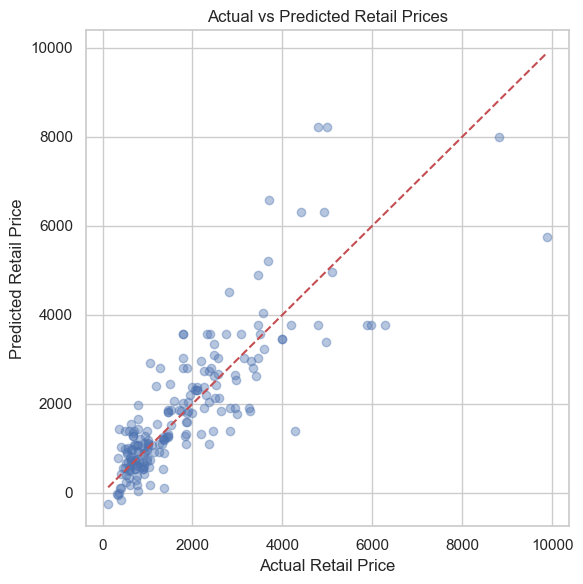

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Retail Price")
plt.ylabel("Predicted Retail Price")
plt.title("Actual vs Predicted Retail Prices")
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
# Create a Series of all coefficients
all_coefs = pd.Series(lr.coef_, index=X.columns)

# Sort by absolute value (most influential first)
all_coefs_sorted = all_coefs.reindex(all_coefs.abs().sort_values(ascending=False).index)

# Print all
pd.set_option('display.max_rows', None)  # Show all rows
print(all_coefs_sorted)


BRAND_hermes                      2.924830e+03
CONDITION_good                   -1.200965e+03
BRAND_chanel                      1.084303e+03
CONDITION_giftable                9.558523e+02
CATEGORY_shop all bags            6.912007e+02
BRAND_goyard                      5.661274e+02
CONDITION_very good              -5.278510e+02
BRAND_louis vuitton               4.820326e+02
BRAND_givenchy                   -3.560401e+02
BRAND_off-white                  -3.385796e+02
BRAND_valentino garavani         -3.217943e+02
CATEGORY_clutch & evening bags   -3.122517e+02
BRAND_bottega veneta             -3.086681e+02
BRAND_stella mccartney           -3.027513e+02
BRAND_prada                      -3.007838e+02
CATEGORY_bucket bags             -2.698196e+02
BRAND_christian dior              2.633375e+02
BRAND_chloe                      -2.245187e+02
CONDITION_flawed                 -2.137987e+02
CATEGORY_belt bags               -2.058558e+02
BRAND_versace                    -1.556655e+02
BRAND_celine 

In [33]:
# Extract and filter coefficients for BRAND columns
brand_coefs = pd.Series(lr.coef_, index=X.columns)
brand_effects = brand_coefs[brand_coefs.index.str.startswith('BRAND_')]

# Sort by impact
brand_effects_sorted = brand_effects.sort_values(ascending=False)
print(brand_effects_sorted.head(10))  # Top 10 brands with positive effect


BRAND_hermes            2924.829517
BRAND_chanel            1084.303301
BRAND_goyard             566.127419
BRAND_louis vuitton      482.032630
BRAND_christian dior     263.337502
BRAND_celine             135.222408
BRAND_gucci              116.215462
BRAND_saint laurent       98.759494
BRAND_fendi              -22.995006
BRAND_balenciaga         -30.923693
dtype: float64


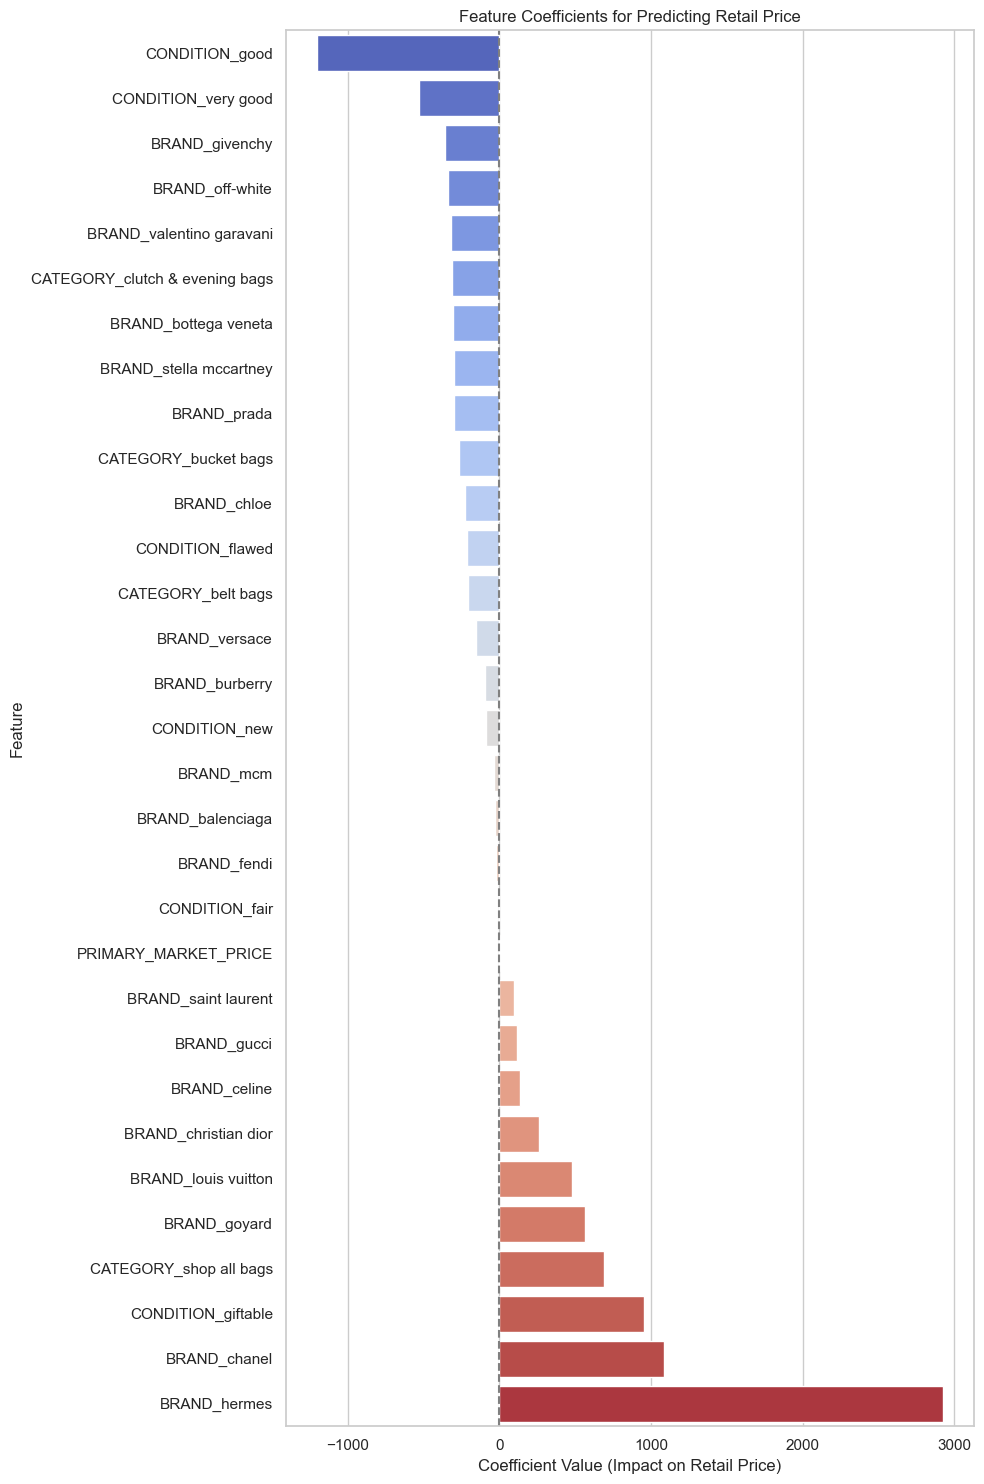

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create and sort coefficient series
all_coefs = pd.Series(lr.coef_, index=X.columns)
coefs_sorted = all_coefs.sort_values()

# Plot
plt.figure(figsize=(10, len(coefs_sorted) // 2))
sns.barplot(x=coefs_sorted.values, y=coefs_sorted.index, palette='coolwarm')

plt.title("Feature Coefficients for Predicting Retail Price")
plt.xlabel("Coefficient Value (Impact on Retail Price)")
plt.ylabel("Feature")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()
